In [21]:
import pandas as pd
import numpy as np
import zipfile
import os
from google.colab import files
import matplotlib.pyplot as plt
!pip install missingno

In [7]:
uploaded = files.upload()
# Extract the uploaded zip
for filename in uploaded.keys():
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall("extracted")
    print("Extracted to /content/extracted")

Saving Argentina.zip to Argentina (1).zip
Extracted to /content/extracted


In [23]:
# Pick a file inside the zip
with zipfile.ZipFile("Argentina.zip") as z:
    with z.open("ar_properties.csv") as f:
        df = pd.read_csv(f)
# Preview data
print(df.head())
print(df.info())

                         id    ad_type  start_date    end_date  created_on  \
0  wdQ5hWhv8P14T7Sh9g4QCg==  Propiedad  2020-12-25  9999-12-31  2020-12-25   
1  nnMBYZ4RMRY+vm753EtA+g==  Propiedad  2020-12-25  9999-12-31  2020-12-25   
2  +dnVA1K6JxzL1zAjOEQ1pA==  Propiedad  2020-12-25  2020-12-29  2020-12-25   
3  dLHXKN5/sRZpm9Yk0yI2nA==  Propiedad  2020-12-25  2020-12-29  2020-12-25   
4  wtw/k887EPipd37UYHKb1Q==  Propiedad  2020-12-25  9999-12-31  2020-12-25   

         lat        lon         l1                        l2        l3  ...  \
0 -32.716652 -68.642692  Argentina                   Mendoza       NaN  ...   
1 -24.797723 -65.467514  Argentina                     Salta       NaN  ...   
2 -34.919373 -58.020591  Argentina    Bs.As. G.B.A. Zona Sur  La Plata  ...   
3 -34.919455 -58.024807  Argentina    Bs.As. G.B.A. Zona Sur  La Plata  ...   
4 -34.364924 -58.783143  Argentina  Bs.As. G.B.A. Zona Norte   Escobar  ...   

  bathrooms surface_total  surface_covered  price  curre

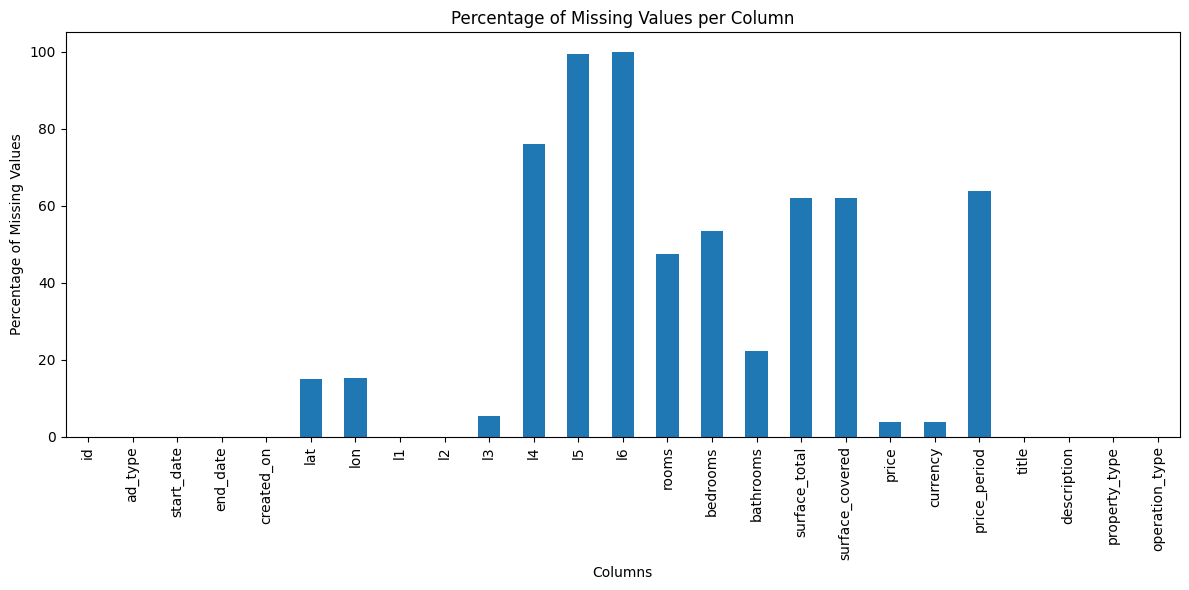

In [16]:
# Calculate % of missing values per column
missing_percentages = df.isnull().sum() / len(df) * 100

# Create a bar chart of missing values
plt.figure(figsize=(12, 6))
missing_percentages.plot(kind='bar')
plt.title('Percentage of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [18]:
df_imputed = df.copy()   # Make a copy of the dataset

# Find numerical and categorical columns with missing values
numerical_cols_with_missing = df_imputed.select_dtypes(include=np.number).columns[
    df_imputed.select_dtypes(include=np.number).isnull().any()
]
categorical_cols_with_missing = df_imputed.select_dtypes(include='object').columns[
    df_imputed.select_dtypes(include='object').isnull().any()
]

# Fill missing values in numerical columns with median
for col in numerical_cols_with_missing:
    median_value = df_imputed[col].median()
    df_imputed[col] = df_imputed[col].fillna(median_value)

# Fill missing values in categorical columns with mode
for col in categorical_cols_with_missing:
    mode_value = df_imputed[col].mode()
    if not mode_value.empty:
        df_imputed[col] = df_imputed[col].fillna(mode_value[0])

# Check if all missing values were handled
display(df_imputed[numerical_cols_with_missing].isnull().sum())
display(df_imputed[categorical_cols_with_missing].isnull().sum())

,0
lat,0
lon,0
l6,1000000
rooms,0
bedrooms,0
bathrooms,0
surface_total,0
surface_covered,0
price,0


,0
l3,0
l4,0
l5,0
currency,0
price_period,0
description,0


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# 1. Select features and target variable
features = ['ad_type', 'property_type', 'operation_type', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'currency', 'price_period']
target = 'price'

X = df_imputed[features]
y = df_imputed[target]

# 2. Handle categorical features
X = pd.get_dummies(X, columns=['ad_type', 'property_type', 'operation_type', 'currency', 'price_period'], drop_first=True)

# 3. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Import and 5. Instantiate and train a Decision Tree model
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# 6. Make predictions
y_pred = model.predict(X_test)

# 7. Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 61449480554276.39
Root Mean Squared Error: 7838971.906715599


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# 1. Select features and target variable from the original DataFrame df
features = ['ad_type', 'property_type', 'operation_type', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'currency', 'price_period']
target = 'price'

# Drop rows where the target variable 'price' is missing, as the model cannot be trained or evaluated on these.
# Include the target variable in the subset for dropping NaNs
df_cleaned = df.dropna(subset=[target] + features)

X = df_cleaned[features]
y = df_cleaned[target]

# 2. Apply one-hot encoding to the categorical features
# Use dummy_na=True to explicitly handle NaN values in categorical columns
X = pd.get_dummies(X, columns=['ad_type', 'property_type', 'operation_type', 'currency', 'price_period'], dummy_na=True, drop_first=True)

# 3. Split the processed dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Instantiate a DecisionTreeRegressor model
model_no_imputation = DecisionTreeRegressor(random_state=42)

# 5. Train the Decision Tree model on the training data containing missing values
model_no_imputation.fit(X_train, y_train)

# 6. Make predictions on the test data containing missing values
y_pred_no_imputation = model_no_imputation.predict(X_test)

# 7. Evaluate the model's performance
mse_no_imputation = mean_squared_error(y_test, y_pred_no_imputation)
rmse_no_imputation = np.sqrt(mse_no_imputation)

# 8. Print the calculated MSE and RMSE values
print(f'Mean Squared Error (No Imputation): {mse_no_imputation}')
print(f'Root Mean Squared Error (No Imputation): {rmse_no_imputation}')

Mean Squared Error (No Imputation): 1568443921575.9482
Root Mean Squared Error (No Imputation): 1252375.3117879434


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Select features and target variable from the original DataFrame df
features = ['ad_type', 'property_type', 'operation_type', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'currency', 'price_period']
target = 'price'

# Drop rows where the target variable 'price' is missing, as the model cannot be trained or evaluated on these.
# Include the target variable in the subset for dropping NaNs
df_cleaned = df.dropna(subset=[target] + features)

X = df_cleaned[features]
y = df_cleaned[target]

# 2. Apply one-hot encoding to the categorical features
# Use dummy_na=True to explicitly handle NaN values in categorical columns
X = pd.get_dummies(X, columns=['ad_type', 'property_type', 'operation_type', 'currency', 'price_period'], dummy_na=True, drop_first=True)

# 3. Split the processed dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Instantiate a DecisionTreeRegressor model
model_no_imputation = DecisionTreeRegressor(random_state=42)

# 5. Train the Decision Tree model on the training data containing missing values
model_no_imputation.fit(X_train, y_train)

# 6. Make predictions on the test data containing missing values
y_pred_no_imputation = model_no_imputation.predict(X_test)

# 7. Evaluate the model's performance
mse_no_imputation = mean_squared_error(y_test, y_pred_no_imputation)
rmse_no_imputation = np.sqrt(mse_no_imputation)

# 8. Print the calculated MSE and RMSE values
print(f'Mean Squared Error (No Imputation): {mse_no_imputation}')
print(f'Root Mean Squared Error (No Imputation): {rmse_no_imputation}')

Mean Squared Error (No Imputation): 1568443921575.9482
Root Mean Squared Error (No Imputation): 1252375.3117879434


In [26]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Instantiate an XGBRegressor model
# Use default parameters for simplicity, XGBoost handles NaN by default
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the XGBoost model on the training data X_train and y_train.
# X_train and y_train here already contain the data after handling categorical features and dropping rows with missing target.
model_xgb.fit(X_train, y_train)

# Make predictions on the testing data X_test
y_pred_xgb = model_xgb.predict(X_test)

# Calculate the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

# Print the calculated MSE and RMSE values
print(f'XGBoost Mean Squared Error: {mse_xgb}')
print(f'XGBoost Root Mean Squared Error: {rmse_xgb}')

XGBoost Mean Squared Error: 693149312351.7819
XGBoost Root Mean Squared Error: 832555.8914281862


In [27]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Instantiate a lgb.LGBMRegressor model. Use default parameters for simplicity.
model_lgb = lgb.LGBMRegressor(random_state=42)

# Train the LightGBM model on the training data X_train and y_train.
# X_train and y_train here already contain the data after handling categorical features and dropping rows with missing target.
model_lgb.fit(X_train, y_train)

# Make predictions on the testing data X_test.
y_pred_lgb = model_lgb.predict(X_test)

# Calculate the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) of the predictions compared to the actual values y_test.
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mse_lgb)

# Print the calculated MSE and RMSE values, clearly labeling them as LightGBM results.
print(f'LightGBM Mean Squared Error: {mse_lgb}')
print(f'LightGBM Root Mean Squared Error: {rmse_lgb}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 77177, number of used features: 16
[LightGBM] [Info] Start training from score 348385.577815
LightGBM Mean Squared Error: 737039319743.4855
LightGBM Root Mean Squared Error: 858509.9415519226


In [30]:
# 1. Create a dictionary to store the RMSE values
rmse_comparison = {
    'Decision Tree with Imputation': rmse,
    'Decision Tree without Imputation': rmse_no_imputation,
    'XGBoost': rmse_xgb,
    'LightGBM': rmse_lgb
}

# 2. Display the comparison table or dictionary
print("RMSE Comparison of Different Models and Imputation Strategies:")
for model, score in rmse_comparison.items():
    print(f"- {model}: {score:.2f}")

# 3. Briefly analyze and comment on the results
print("\nAnalysis:")
best_model = min(rmse_comparison, key=rmse_comparison.get)
print(f"Based on RMSE, the best performing model is the {best_model}.")
print("Both XGBoost and LightGBM, which handle missing values natively, show significantly lower RMSE compared to the Decision Tree models.")
print("The Decision Tree without explicit imputation performed much better than the Decision Tree with simple median/mode imputation, indicating that letting the tree handle NaNs directly was more effective than the simple imputation strategy used.")

RMSE Comparison of Different Models and Imputation Strategies:
- Decision Tree with Imputation: 7838971.91
- Decision Tree without Imputation: 1252375.31
- XGBoost: 832555.89
- LightGBM: 858509.94

Analysis:
Based on RMSE, the best performing model is the XGBoost.
Both XGBoost and LightGBM, which handle missing values natively, show significantly lower RMSE compared to the Decision Tree models.
The Decision Tree without explicit imputation performed much better than the Decision Tree with simple median/mode imputation, indicating that letting the tree handle NaNs directly was more effective than the simple imputation strategy used.
